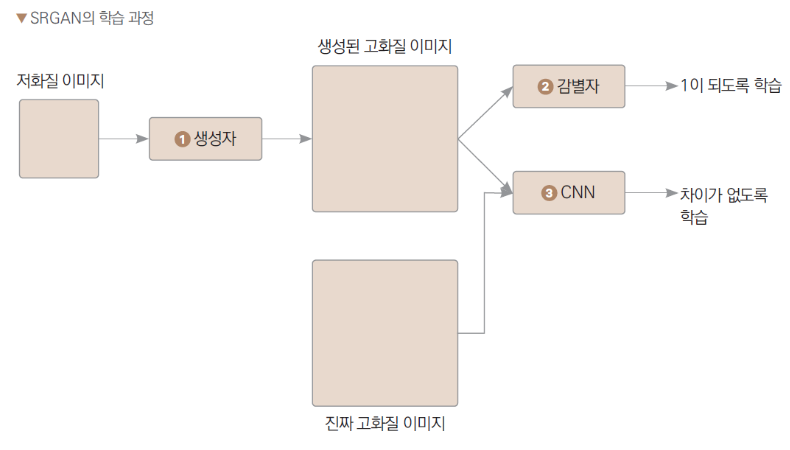

In [1]:
!unzip '/content/drive/MyDrive/data/CelebA/Img/img_align_celeba.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 extracting: img_a

In [2]:
import glob
len( glob.glob('/content/img_align_celeba/*.jpg') )

202599

데이터셋

In [3]:
import glob
import torchvision.transforms as  tf
from torch.utils.data import Dataset
from PIL import Image

In [4]:
class CelebA(Dataset):
  def __init__(self):
    self.imgs = glob.glob('/content/img_align_celeba/*.jpg')
    # 입력용 이미지 생성
    self.low_res_tf = tf.Compose([
        tf.Resize((32,32)),
        tf.ToTensor(),
        tf.Normalize((0.4,0.4,0.4),(0.2,0.2,0.2))
    ])

    # 정답용 이미지 생성
    self.high_res_tf = tf.Compose([
        tf.Resize( (64,64) ),
        tf.ToTensor(),
        tf.Normalize( (0.4,0.4,0.4), (0.2,0.2,0.2) )
    ])
  def __len__(self):
    return len(self.imgs)
  def __getitem__(self, index):
    img = Image.open(self.imgs[index])
    # 저화질 이미지는 입력
    img_low_res = self.low_res_tf(img)
    # 고화질 이미지는 정답
    img_high_res = self.high_res_tf(img)
    return [img_low_res, img_high_res]

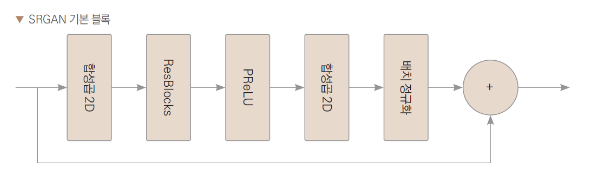

In [5]:
import torch.nn as nn
class ResidualBlock(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channel)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channel)
  def forward(self, x):
    x_ = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.prelu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    # 합성곱층을 거친후 원래의 텐서와 더해줌
    x = x_ + x
    return x

기본블럭을 거치고 나면 이미지 크기를 키우는 업샘플링 단계

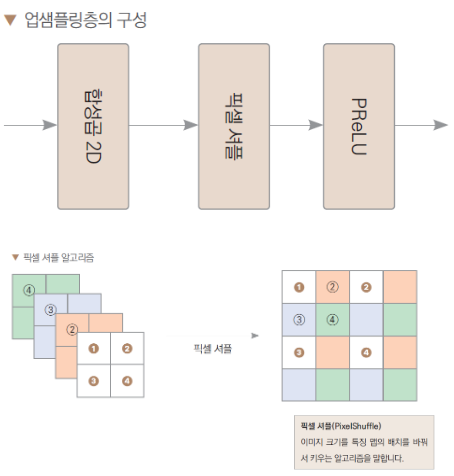

- 업샘플링  
  - 트랜스포즈합성곱을 사용 : 학습가능한 가중치를 이용해 이미지를 키움
  - 픽셀셔플 : 가중치가 없음, 이미지의 채널을 적절하게 섞는 것으로 이미지 크기를 키우는 알고리즘
    - 학습가능한 가중치가 없으므로 바로 픽셀셔플을 이용하면 특징맵으로 부터 정보를 복원할 수가 없음, 픽셀셔플을 하기전에 합성곱을 이용해서 특징을 한번더 추출한 다음 픽셀셔플을 해야 함
    - 이미지의 해상도를 높일때 사용하는 알고리즘

In [6]:
class UpSample(nn.Sequential):
  def __init__(self,in_channel, out_channel):
    super(UpSample, self).__init__(
        nn.Conv2d(in_channel,out_channel, kernel_size=3,padding=1),
        nn.PixelShuffle(upscale_factor=2),
        nn.PReLU()
        )

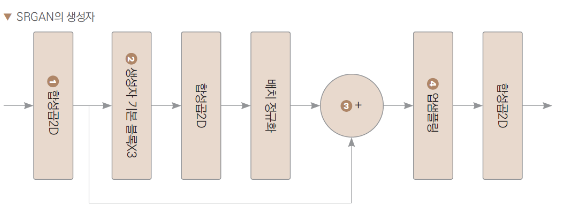

In [7]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    # 첫번째 합성곱층
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    # 합성곱 블럭
    self.res_blocks = nn.Sequential(
        ResidualBlock(64,64),
        ResidualBlock(64,64),
        ResidualBlock(64,64)
    )

    self.conv2 = nn.Conv2d(64,64,kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(64)

    # 업셈플링층
    self.upsample_blocks = nn.Sequential(
        UpSample(64,256)
    )

    # 마지막 합성곱층
    self.conv3 = nn.Conv2d(64, 3, kernel_size=9, padding=4)

  def forward(self, x):
    # 첫번째 합성곱층
    x = self.conv1(x)
    # 합성곱 블럭을 거친 결과와 더하기 위해서 값을 저장
    x_ = x

    # 합성곱 블럭
    x = self.res_blocks(x)
    x = self.conv2(x)
    x = self.bn(x)

    # 합성곱 블럭과 첫 번째 합성곱층의 결과를 더함
    x = x + x_

    # 업셈플링 블럭
    x = self.upsample_blocks(x)

    # 마지막 합성곱층
    x = self.conv3(x)

    return x

감별자

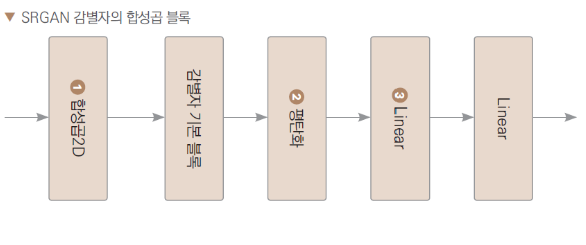

감별자 기본 블럭
  - 한번 거칠때 마다 이미지의 크기가 절반으로 줄어드는 합성곱층

In [8]:
class DiscBlock(nn.Module):
  def __init__(self,in_channels, out_channels) -> None:
    super(DiscBlock, self).__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )
  def forward(self, x):
    return self.layers(x)

감별자

In [9]:
import torch
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3,64, kernel_size=3, padding=1),
        nn.LeakyReLU()
    )
    self.blocks = DiscBlock(64,64)
    self.fc1 = nn.Linear(65536, 1024)
    self.activation = nn.LeakyReLU()
    self.fc2 = nn.Linear(1024, 1)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    # 합성곱층
    x = self.conv1(x)
    x = self.blocks(x)

    # 1차원으로 펼쳐줌
    x = torch.flatten(x, start_dim=1)

    # 이진분류
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    x = self.sigmoid(x)

    return x

CNN 특징 추출기 정의
  - VGG19

In [10]:
import torch
from torchvision.models.vgg import vgg19

In [11]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    # 사전 학습된 vgg19 모델 정의
    vgg19_model = vgg19(pretrained = True)
    # vgg19의 9개 층만 이용(그 이상 층을 사용하면 이미지의 최대 크기보다 줄어들게 됨)
    self.feature_extractor = nn.Sequential(
        *list(vgg19_model.features.children())[:9]
    )
  def forward(self, img):
    return self.feature_extractor(img)

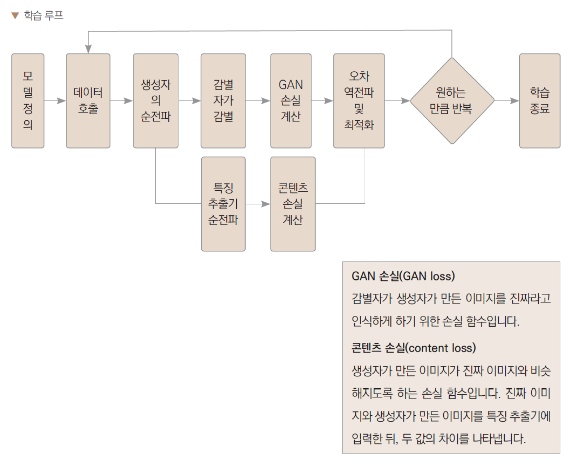

학습에 필요한 요소 정의

In [12]:
import tqdm
from torch.utils.data import DataLoader
from torch.optim.adam import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = CelebA()
batch_size = 8
loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
# 생성자와 감별자 정의
G = Generator().to(device)
D = Discriminator().to(device)
feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval()

# 옵티마이져 정의
G_optim = Adam(G.parameters(), lr= 1e-4)
D_optim = Adam(D.parameters(), lr= 1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 99.3MB/s]


학습루프

In [ ]:
for epoch in range(1):
  iterator = tqdm.tqdm(loader)
  for i, (low_res, hight_res) in enumerate(iterator):
    # 기울기 초기화
    G_optim.zero_grad()
    D_optim.zero_grad()

    # 진짜이미지와 가짜이미지의 정답
    label_true = torch.ones(batch_size, dtype=torch.float32).to(device)
    label_false = torch.zeros(batch_size, dtype=torch.float32).to(device)

    # 생성자 학습
    fake_hr = G(low_res.to(device))
    GAN_loss = nn.MSELoss()( D(fake_hr), label_true)
    # CNN 특징 추출기로 부터 추출된 특징 비교
    # 가짜 이미지의 특징 추출
    fake_features = feature_extractor(fake_hr)
    # 진짜 이미지의 특징 추출
    real_features = feature_extractor(hight_res.to(device))
    # 둘의 차이 비교
    content_loss = nn.L1Loss()(fake_features, real_features)
    logg_G = content_loss + 0.001 * GAN_loss
    logg_G.backward()
    G_optim.step()

    # 감별자 학습
    # 진짜 이미지의 손실
    real_loss = nn.MSELoss()( D(hight_res.to(device)), label_true)
    # 가짜 이미지의 손실
    fake_loss = nn.MSELoss()( D(fake_hr.detach()), label_false)
    # 두 손실의 평균값을 최종 오차로 설정
    loss_D = (real_loss + fake_loss) / 2
    # 오차 역적파
    loss_D.backward()
    D_optim.step()

    iterator.set_description(f'epoch:{epoch+1} G_loss:{GAN_loss} D_loss:{loss_D}')

torch.save(G.state_dict(),'/content/drive/MyDrive/SRGAN_G.pth')
torch.save(D.state_dict(),'/content/drive/MyDrive/SRGAN_D.pth')

모델 성능평가

In [14]:
import matplotlib.pyplot as plt

In [ ]:
G.load_state_dict(torch.load('/content/drive/MyDrive/SRGAN_G.pth', map_location = device))

In [ ]:
with torch.no_grade():
  low_res, high_res = dataset[0]
  # 생성자 입력
  input_tensor = torch.unsqueeze(low_res, dim=0).to(device)
  # 생성자가 생성한 고화질 이미지
  pred = G(input_tensor)
  pred = pred.squeeze()
  pred = pred.permute(1,2,0).cpu().numpy()
  # 저화질 이미지의 채널 차원을 가장 마지막으로
  low_res = low_res.permute(1,2,0).numpy()

  # 저화질 입력과 생성자가 만든 고화질 이미지 비교
  plt.subplot(1,2,1)
  plt.title('low resolution image')
  plt.imshow(low_res)
  plt.subplot(1,2,2)
  plt.imshow(pred)
  plt.title('predicted high resolution image')
  plt.show()